# Distributed Dask Demo

_**Connect to a Dask Cluster on Fargate and run analytics**_

This notebook works well with the `conda_python3` on classic SageMaker Notebook Instances with the `ml.t2.large` instance.

---

This notebook assumes that a Dask cluster exists on AWS Fargate (see [this blog post](https://aws.amazon.com/blogs/machine-learning/machine-learning-on-distributed-dask-using-amazon-sagemaker-and-aws-fargate/)). It creates a Dask distributed client that connects to this cluster using service discovery, the it reads the NYC taxi dataset from an S3 bucket and illustrates how to perform basic analytics tasks and machine learning tasks. 

1. Then the cluster is scaled up to demonstrate that the time taken for the analytics task decreases as the cluster scales up. 

1. A ML task is demonstrated on the same dataset using Dask-ML. 

**It is important to stick to the exact same version of the dependencies as installed in this notebook and the Dask container version used by the Cloud Formation templates. Any changes to anything in this notebook or cloud formation scripts would most likely cause things to break and lead to a dependency hell.**

---

---

## Contents

1. [Prepare the environment](#Prepare-the-environment)
1. [Connect to the Dask Cluster](#Connect-to-the-Dask-Cluster)
1. [Scale out the cluster](#Scale-up-the-cluster)
1. [Exploratory Data Analytics](#Exploratory-Data-Analytics)
1. [Scale out the cluster even more to see if the operations become faster](#Scale-out-the-cluster-even-more-to-see-if-the-operations-become-faster)
1. [Machine Learning with Dask](#Machine-Learning-with-Dask)
1. [Scale in the cluster when done](#Scale-in-the-cluster-when-done)

---

## Prepare the environment

Install the exact version of Python packages that work with the Dask cluster (based on the container used by the Dask cluster, see cloud formation templates).

In [1]:
!pip install dask==2.20.0 distributed==2.20.0 s3fs==0.4.0 pyarrow==6.0.1 dask-glm==0.2.0 cytoolz==0.8.2 dask-ml==1.6.0

     |████████████████████████████████| 826 kB 22.2 MB/s            
     |████████████████████████████████| 644 kB 66.4 MB/s            
     |████████████████████████████████| 386 kB 69.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 140 kB 64.7 MB/s            
     |████████████████████████████████| 900 kB 72.1 MB/s            
     |████████████████████████████████| 891 kB 71.9 MB/s            
     |████████████████████████████████| 889 kB 65.9 MB/s            
     |████████████████████████████████| 884 kB 69.8 MB/s            
     |████████████████████████████████| 848 kB 61.8 MB/s            
     |████████████████████████████████| 847 kB 67.0 MB/s            
     |████████████████████████████████| 848 kB 66.8 MB/s            
     |████████████████████████████████| 843 kB 66.2 MB/s            
     |████████████████████████████████| 843 kB 37.6 MB/s            
     |████████████████████████████████| 834 kB 39.8 MB/s      

In [1]:
import os
import dask
import s3fs
import time
import distributed
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client
from sklearn.metrics import mean_squared_error
from dask_ml.model_selection import train_test_split

---

## Connect to the Dask Cluster

With the right packages installed, now connect to the Dask cluster. Any Dask operations we do after that are automatically done at the cluster (rather than on this notebook).

As created, the Dask cluster only has a single task (note we are not using the term node, recall the EMR cluster where we were talking in terms of driver note, core nodes and task nodes). Since this Dask cluster installation is on [AWS Fargate](https://aws.amazon.com/fargate/) which is a serverless compute engine so we dont have to worry about setting up EC2 instances, that is handled behind the scenes for us. We only need to specify the container that we need to run on the _Dask Scheduler_ and _Dask Workers_.

In [2]:
# enable this client for fargate distributed cluster testing
client = Client('Dask-Scheduler.local-dask:8786')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

dask
+-----------------------+---------+
|                       | version |
+-----------------------+---------+
| client                | 2.20.0  |
| scheduler             | 2.14.0  |
| tcp://11.0.3.202:9000 | 2.14.0  |
+-----------------------+---------+

distributed
+-----------------------+---------+
|                       | version |
+-----------------------+---------+
| client                | 2.20.0  |
| scheduler             | 2.14.0  |
| tcp://11.0.3.202:9000 | 2.14.0  |
+-----------------------+---------+

msgpack
+-----------------------+---------+
|                       | version |
+-----------------------+---------+
| client                | 1.0.2   |
| scheduler             | 1.0.0   |
| tcp://11.0.3.202:9000 | 1.0.0   |
+-----------------------+---------+

numpy
+-----------------------+---------+
|                       | ver

The Dask cluster is also accessible via a web portal (see instructions in the blog post). For this cluster the web portal is accessible at [http://dask-loadb-1pyknky9jddwq-9a111e1ac4b115dd.elb.us-east-1.amazonaws.com/status](http://dask-loadb-1pyknky9jddwq-9a111e1ac4b115dd.elb.us-east-1.amazonaws.com/status).

![](./img/dask-ui-1.png)

---

# Scale out the cluster

Before we can use the cluster we need to scale it up to add some compute power to it. The cloud formation template specify the cluster task nodes to have 2 vCPUs and 4 GB of RAM.

In [5]:
#enable this  when cluster is running on Fargate to scale out your cluster. 
!sudo aws ecs update-service --service Dask-Workers --desired-count 6 --cluster Fargate-Dask-Cluster

{
    "service": {
        "serviceArn": "arn:aws:ecs:us-east-1:015469603702:service/Fargate-Dask-Cluster/Dask-Workers",
        "serviceName": "Dask-Workers",
        "clusterArn": "arn:aws:ecs:us-east-1:015469603702:cluster/Fargate-Dask-Cluster",
        "loadBalancers": [],
        "serviceRegistries": [
            {
                "registryArn": "arn:aws:servicediscovery:us-east-1:015469603702:service/srv-kwhqanurpvkf7bwr"
            }
        ],
        "status": "ACTIVE",
        "desiredCount": 6,
        "runningCount": 1,
        "pendingCount": 0,
        "launchType": "FARGATE",
        "platformVersion": "LATEST",
        "platformFamily": "Linux",
        "taskDefinition": "arn:aws:ecs:us-east-1:015469603702:task-definition/cloudformation-dask-workers-v1:7",
        "deploymentConfiguration": {
            "deploymentCircuitBreaker": {
                "enable": false,
                "rollback": false
            },
            "maximumPercent": 200,
            "minimu

After initiating the scale up of cluster give it about 5 minutes for the additional compute to become available. Note the CPU and memory resources now available to the cluster.This cluster now has 6 works with 12 cores and 24GB RAM (recall we had 2 vCPUs and 4 GB per worker).

In [7]:
time.sleep(300)
client.restart()

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 6 Cores: 12 Memory: 24.58 GB


---

## Exploratory Data Analytics

We will be reading the new york taxi dataset for 2021 and running some analytics on it.

1. Note the similarity between the Dask dataframe API and the Pandas API.

1. Note that we are able to read all the files in one call using the `*` wildcard character.

In [209]:
# read the data directly from S3, data is accessible with anonymous credentials
df = dd.read_csv('s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-*.csv',
                 storage_options={'anon': True},
                 parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

The data frame is lazy loaded and is automatically partitioned (you can control this by specifying the `blocksize` parameter, see [read_csv](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html)).

In [9]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=57,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


How many rows did we read? Well, the `shape` attribute does not give us the number of rows because this dataframe is not yet been loaded into the memory only a DAG has been created for reading it. `shape` will tell us the number of columns, to get the number of rows we will have to do a `len`. The data contains about ~31 million rows.

In [10]:
df.shape

(Delayed('int-3fbe140b-9693-4cce-af86-bcd107caf203'), 19)

In [13]:
%%time
print(f"{len(df):,}") 

30,904,308
CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 17.5 s


Let's find out average trip distance and total count.

In [14]:
%%time
start = time.perf_counter()
results = df[['trip_distance', 'total_amount']].mean().compute().to_frame().reset_index()
end = time.perf_counter()

# set column names for the resulting dataframe
results.columns = ["feature", "mean"]
results

CPU times: user 64.5 ms, sys: 0 ns, total: 64.5 ms
Wall time: 19.6 s


,feature,mean
0,trip_distance,6.922689
1,total_amount,19.696305


---


## Scale out the cluster even more to see if the operations become faster

It would make sense to say that if we double the size of the cluster then the time taken for the analytics task should reduce. Let us do that and see if it happens. We look at the cluster web portal to see that the number of tasks have increased.


In [5]:
#enable this  when cluster is running on Fargate to scale out your cluster. 
!sudo aws ecs update-service --service Dask-Workers --desired-count 12 --cluster Fargate-Dask-Cluster
time.sleep(300)
client.restart()

{
    "service": {
        "serviceArn": "arn:aws:ecs:us-east-1:015469603702:service/Fargate-Dask-Cluster/Dask-Workers",
        "serviceName": "Dask-Workers",
        "clusterArn": "arn:aws:ecs:us-east-1:015469603702:cluster/Fargate-Dask-Cluster",
        "loadBalancers": [],
        "serviceRegistries": [
            {
                "registryArn": "arn:aws:servicediscovery:us-east-1:015469603702:service/srv-kwhqanurpvkf7bwr"
            }
        ],
        "status": "ACTIVE",
        "desiredCount": 1,
        "runningCount": 12,
        "pendingCount": 0,
        "launchType": "FARGATE",
        "platformVersion": "LATEST",
        "platformFamily": "Linux",
        "taskDefinition": "arn:aws:ecs:us-east-1:015469603702:task-definition/cloudformation-dask-workers-v1:7",
        "deploymentConfiguration": {
            "deploymentCircuitBreaker": {
                "enable": false,
                "rollback": false
            },
            "maximumPercent": 200,
            "minim

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 12 Cores: 24 Memory: 49.15 GB


![](img/dask-ui-2.png)
![](img/dask-ui-3.png)

In [17]:
%%time
start = time.perf_counter()
results = df[['trip_distance', 'total_amount']].mean().compute().to_frame().reset_index()
end = time.perf_counter()

# set column names for the resulting dataframe
results.columns = ["feature", "mean"]
results

CPU times: user 57.5 ms, sys: 0 ns, total: 57.5 ms
Wall time: 10.1 s


,feature,mean
0,trip_distance,6.922689
1,total_amount,19.696305


So as we can see the time taken reduced to almost half of what it was earlier. **_Doubling the size of the cluster reduced the time taken by 50%, horizontal scaling at work._**

Let's keep doing this and see if we can reduce this further!!!

In [18]:
#enable this  when cluster is running on Fargate to scale out your cluster. 
!sudo aws ecs update-service --service Dask-Workers --desired-count 24 --cluster Fargate-Dask-Cluster
time.sleep(300)
client.restart()

{
    "service": {
        "serviceArn": "arn:aws:ecs:us-east-1:015469603702:service/Fargate-Dask-Cluster/Dask-Workers",
        "serviceName": "Dask-Workers",
        "clusterArn": "arn:aws:ecs:us-east-1:015469603702:cluster/Fargate-Dask-Cluster",
        "loadBalancers": [],
        "serviceRegistries": [
            {
                "registryArn": "arn:aws:servicediscovery:us-east-1:015469603702:service/srv-kwhqanurpvkf7bwr"
            }
        ],
        "status": "ACTIVE",
        "desiredCount": 24,
        "runningCount": 12,
        "pendingCount": 0,
        "launchType": "FARGATE",
        "platformVersion": "LATEST",
        "platformFamily": "Linux",
        "taskDefinition": "arn:aws:ecs:us-east-1:015469603702:task-definition/cloudformation-dask-workers-v1:7",
        "deploymentConfiguration": {
            "deploymentCircuitBreaker": {
                "enable": false,
                "rollback": false
            },
            "maximumPercent": 200,
            "mini

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 24 Cores: 48 Memory: 98.30 GB


In [20]:
%%time
start = time.perf_counter()
results = df[['trip_distance', 'total_amount']].mean().compute().to_frame().reset_index()
end = time.perf_counter()

# set column names for the resulting dataframe
results.columns = ["feature", "mean"]
results

CPU times: user 48.7 ms, sys: 3.51 ms, total: 52.2 ms
Wall time: 6.44 s


,feature,mean
0,trip_distance,6.922689
1,total_amount,19.696305


Here is a screenshot from the cluster web portal about the memory and CPU utilization from all the tasks.
![](img/dask-ui-4.png)

So as we can see the time taken reduced to almost 70% of what it was earlier. **_Quadrupling the size of the cluster reduced the time taken by 65%, horizontal scaling at work._**

We can continue in the same vein and we would soon find out that further increasing the size of the cluster provides little or no benefit because after a point the overhead of distributing the data between nodes and then combining the results exceeds the benefits provided by parallelism.

#### Count the total trip distance and count for each vendor

In [215]:
%%time
df.groupby('VendorID').agg({'passenger_count':'count', 'trip_distance': 'sum'}).astype(int).compute()

CPU times: user 51.9 ms, sys: 0 ns, total: 51.9 ms
Wall time: 5.6 s


,passenger_count,trip_distance
VendorID,,
1,9111983,27321231
2,20313630,185618682
5,0,500
6,0,1000489


### Selecting top 10 rides based on fare amount

In [234]:
%%time
most_paid_rides_dask = df[['PULocationID', 'fare_amount']].nlargest(10, "fare_amount").compute()

CPU times: user 40.4 ms, sys: 0 ns, total: 40.4 ms
Wall time: 5.73 s


In [235]:
most_paid_rides_dask

,PULocationID,fare_amount
394006,141,818283.44
360061,161,398466.38
601843,234,395854.44
121898,161,6965.00
108758,140,6960.50
294648,238,6010.00
121293,148,5954.00
407884,100,4969.00
33124,4,3554.70
176847,143,3009.00


Clearly these represent anomalies in the data, a fare amount of hundereds of thousdands of dollars!!!!

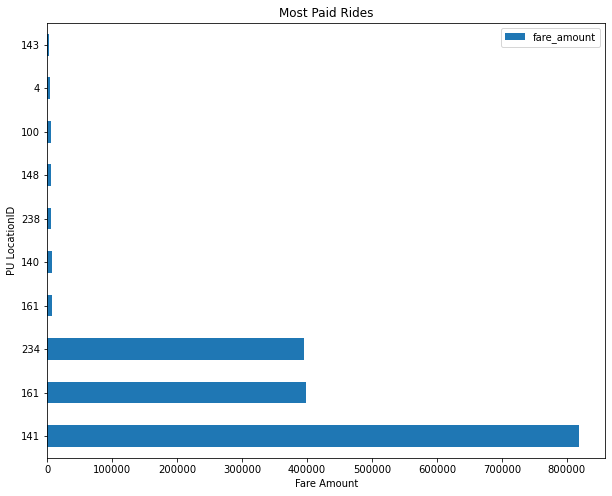

In [231]:
## Visualizing most paid rides through Barplot
most_paid_rides_dask.set_index('PULocationID').plot(kind='barh',stacked=False, figsize=[10,8], legend=True)

plt.title('Most Paid Rides')
plt.xlabel('Fare Amount')
plt.ylabel('PU LocationID')
plt.show()

#### Visualizing trip distance through Barplot

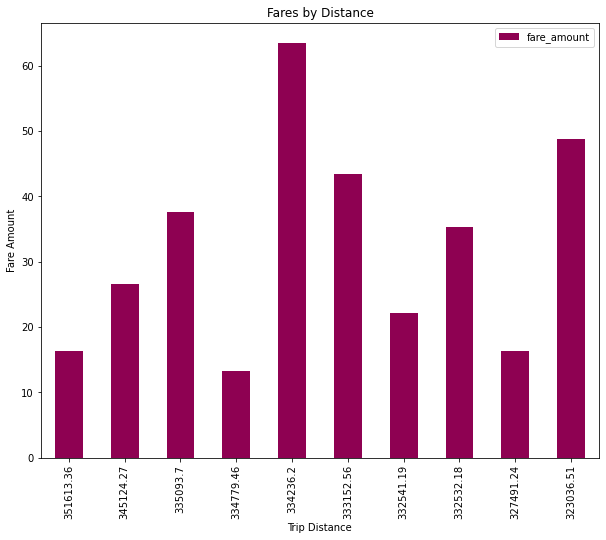

In [232]:
most_paid_rides_dask2 = df[['trip_distance', 'fare_amount']].nlargest(10, "trip_distance").compute()
most_paid_rides_dask2.set_index('trip_distance').plot(kind='bar', colormap='PiYG', stacked=False, figsize=[10,8], legend=True)

plt.title('Fares by Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

### Let's view the quantile distribution, something we should have done earlier

Clearly, anything about the 99th percentile as an anomaly.

In [233]:
%%time
df_quantiles = df[['trip_distance', 'fare_amount']].quantile([0.25, 0.5, 0.75, 0.95, 0.99, 1]).compute().reset_index()
df_quantiles

CPU times: user 496 ms, sys: 0 ns, total: 496 ms
Wall time: 6.17 s


,index,trip_distance,fare_amount
0,0.25,1.42,8.00
1,0.50,2.49,12.50
2,0.75,5.80,24.60
3,0.95,17.70,52.00
4,0.99,24.09,71.90
5,1.00,351613.36,818283.44


---

## Machine Learning with Dask

We create a derived field called `trip_duration` which is the difference between `tpep_dropoff_datetime` and `tpep_pickup_datetime` (note that both these fields were read as datetime when the Dask dataframe was initially created from the CSV files) and train a linear regression model to predict it based on `passenger_count`,`trip_distance`,`fare_amount` and `total_amount`. 

**_Note that the primary objective here is to show how a Dask cluster can be used to train an ML model rather than training the best model possible._**

In [185]:
# read the data directly from S3, data is accessible with anonymous credentials
df = dd.read_csv('s3://bigdatateaching/nyctaxi-yellow-tripdata/csv/2021/yellow_tripdata_2021-12.csv',
                 storage_options={'anon': True},
                 parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

In [186]:
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [187]:
df['trip_duration'].head()

0   0 days 00:17:10
1   0 days 00:16:06
2   0 days 00:14:37
3   0 days 00:09:02
4   0 days 00:13:55
Name: trip_duration, dtype: timedelta64[ns]

Convert the trip duration to hours.

In [188]:

df['trip_duration'] = df['trip_duration']/np.timedelta64(1,'D')
df['trip_duration'] = df['trip_duration'] * 24
df['trip_duration']

Dask Series Structure:
npartitions=6
    float64
        ...
     ...   
        ...
        ...
Name: trip_duration, dtype: float64
Dask Name: getitem, 72 tasks

In [189]:
df['trip_duration'].head()

0    0.286111
1    0.268333
2    0.243611
3    0.150556
4    0.231944
Name: trip_duration, dtype: float64

In [190]:
%%time
df.head()

CPU times: user 11.8 ms, sys: 205 µs, total: 12 ms
Wall time: 2.67 s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2021-12-01 00:19:51,2021-12-01 00:37:01,1.0,9.30,1.0,N,138,141,1,26.5,4.25,0.5,7.60,6.55,0.3,45.70,2.5,1.25,0.286111
1,2,2021-12-01 00:29:07,2021-12-01 00:45:13,2.0,2.76,1.0,N,238,42,2,13.0,0.50,0.5,0.00,0.00,0.3,16.80,2.5,0.00,0.268333
2,1,2021-12-01 00:12:40,2021-12-01 00:27:17,0.0,3.40,1.0,N,239,74,1,13.5,3.00,0.5,2.00,0.00,0.3,19.30,2.5,0.00,0.243611
3,1,2021-12-01 00:10:18,2021-12-01 00:19:20,1.0,1.30,1.0,N,148,87,1,6.5,3.00,0.5,2.05,0.00,0.3,12.35,2.5,0.00,0.150556
4,1,2021-12-01 00:25:12,2021-12-01 00:39:07,1.0,3.10,1.0,N,231,246,1,12.5,3.00,0.5,2.50,0.00,0.3,18.80,2.5,0.00,0.231944


Replace all NAs with 0

In [191]:
df = df.fillna(value=0)

In [192]:
df.shape

(Delayed('int-a8db3db2-a048-462f-bc21-e01b7a00b064'), 20)

In [193]:
len(df)

3214369

**_The next would be to one-hot encode the categroical variables but we run into Dask related errors which so for now we will skip the categorical variables._**

Setup the features and the target variable and then do a train test split. We get the data we need as a pandas dataframe, this should not be needed we should be able to train with the lazy loaded dataframe. We run into errors with the tasks not finding `_sqrt` function, most likely because of using an older version of one of the packages. Updating the packages would mean using a newer container for the Dask scheduler and container, I tried that but that created other problems and for the purpose of this notebook I decided to stick to getting the data locally into this notebook and then relying on Dask to distribute it again, know that this is not how it will work in production.

In [194]:
#x = df[['VendorID','RatecodeID','PULocationID','DOLocationID','passenger_count','trip_distance','fare_amount','total_amount']]
x = df[['passenger_count','trip_distance','fare_amount','total_amount']].compute()

In [195]:
y = df['trip_duration'].compute()

In [196]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [197]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2892932, 321437, 2892932, 321437)

The Dask API does not support dataframe so extract the array as `values`.

In [198]:
training_x = X_train.values
training_y = y_train.values

In [199]:
training_x

array([[ 2.  ,  2.1 , 12.  , 15.3 ],
       [ 1.  ,  0.73,  6.5 , 11.8 ],
       [ 1.  ,  1.03,  6.5 , 12.74],
       ...,
       [ 1.  ,  1.5 ,  8.5 , 15.35],
       [ 2.  ,  1.32,  8.  , 14.75],
       [ 2.  ,  5.5 , 17.5 , 25.5 ]])

In [200]:
testing_x = X_test.values
testing_y = y_test.values

In [201]:
def rmse(preds, actuals):
    error = mean_squared_error(actuals, preds)
    rmse = np.sqrt(error)
    print(rmse)


Train the linear regression model on the Dask cluster.

In [202]:
with joblib.parallel_backend('dask'):
    lr = LinearRegression(random_state=1, fit_intercept=True)
    lr.fit(training_x,training_y)

Prediction and RMSE.

In [203]:
preds = lr.predict(testing_x)
preds

array([0.17399377, 0.22467164, 0.29907055, ..., 0.2305248 , 0.4457403 ,
       0.55201213])

In [204]:
testing_y

array([0.0625    , 0.22388889, 0.25      , ..., 0.18888889, 0.38972222,
       0.53055556])

In [205]:
rmse(preds, testing_y)

0.9388594632958012


Here is the DAG for the linear regression.
![](img/dask-ui-6.png)

**_Here is the CPU utilization across tasks when the model was being trained on all 12 months of data with the data being stored in a Dask dataframe_**.
![](img/dask-ui-5.png)

---

## Scale in the cluster when done
Very important to scale the cluster back to the one task as it was originally

In [1]:
!sudo aws ecs update-service --service Dask-Workers --desired-count 1 --cluster Fargate-Dask-Cluster

{
    "service": {
        "serviceArn": "arn:aws:ecs:us-east-1:015469603702:service/Fargate-Dask-Cluster/Dask-Workers",
        "serviceName": "Dask-Workers",
        "clusterArn": "arn:aws:ecs:us-east-1:015469603702:cluster/Fargate-Dask-Cluster",
        "loadBalancers": [],
        "serviceRegistries": [
            {
                "registryArn": "arn:aws:servicediscovery:us-east-1:015469603702:service/srv-kwhqanurpvkf7bwr"
            }
        ],
        "status": "ACTIVE",
        "desiredCount": 1,
        "runningCount": 24,
        "pendingCount": 0,
        "launchType": "FARGATE",
        "platformVersion": "LATEST",
        "platformFamily": "Linux",
        "taskDefinition": "arn:aws:ecs:us-east-1:015469603702:task-definition/cloudformation-dask-workers-v1:7",
        "deploymentConfiguration": {
            "deploymentCircuitBreaker": {
                "enable": false,
                "rollback": false
            },
            "maximumPercent": 200,
            "minim

Trust but verify!

![](img/dask-ui-7.png)